In [1]:
import numpy as np
from quick.dataset.surface import PlanarCode
from quick.error import phaseflip_error
from pymatching import Matching
import matplotlib.pyplot as plt

## Planar code example
In this tutorial, we will utilize PyMathing to estimate the threshold of the planar code under an independent noise model with perfect syndrome measurements. We only simulate decoding $Z$-type errors using $X$-type stabilizers in this tutorial.
##### Notice: Pymatching is designed exclusively for graph matching and is not suitable for hypergraph matching.
The planar code is a type of **hypergraph product code** derived from classical repetition codes, which serve as its foundational classical codes. Below are the construction of parity check matrix of **hypergraph product code**:

To construct the matrix $H_x$, one employs the hypergraph product of two repetition codes. This process involves using the parity check matrices of two linear codes, denoted as $H_1$ and $H_2$, as inputs. The resulting code is a CSS (Calderbank-Shor-Steane) code, characterized by its check matrices for the $X$ and $Z$ stabilizers. The check matrix for the $X$ stabilizers is expressed as:
\begin{equation*}
H_x = [H_1 \otimes I_{H_{2_{col}}},  I_{H_{1_{row}}} \otimes H_2^T]
\end{equation*}
whereas the check matrix for the $Z$ stabilizers is given by:
\begin{equation*}
H_z = [I_{H_{1_{col}}} \otimes H_2,  H_1^T \otimes I_{H_{2_{row}}}]
\end{equation*}
where $H_1$ has the shape: $H_{1_{row}} \times H_{1_{col}}$, $H_2$ has shape: $H_{2_{row}} \times H_{2_{col}}$ and $I$ denotes the identity matrix.

Below is an example presenting the X check matrix of a planar code with lattice size 3

In [2]:
PC = PlanarCode(3)
H = PC.Hx
print('The X check matrix of this planar code is:')
print(H)

The X check matrix of this planar code is:
[[1 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 0 1 1]
 [0 0 0 0 0 1 0 0 1 0 0 0 1]]


From the Künneth theorem, the $X$ logical operators of the planar code are given by
\begin{equation*}
L_X = 
\begin{pmatrix}
\cal{H}^1 \otimes \cal{H}^0  & 0 \\
0 & \cal{H}^0 \otimes \cal{H}^1 
\end{pmatrix}
\end{equation*}
where $\cal{H}^0$ and $\cal{H}^1$ are the zeroth and first cohomology groups of the length-one chain complex that has the repetition code parity check matrix as its boundary operator. We can use *PlanarCode.logical_op[0]* to represent the $X$ logical operators from our package.

In [3]:
lx = PC.logical_op[0]
print('The X logical operators of this planar code is:')
print(lx)

The X logical operators of this planar code is:
[[1 1 1 0 0 0 0 0 0 0 0 0 0]]


Now that we have the $X$ check matrix and $X$ logicals of the toric code, we can use PyMatching to simulate its performance using the minimum-weight perfect matching decoder and an error model of our choice.

Firstly, we import the Matching class from PyMatching, and use it to construct a Matching object from the $X$ check matrix $H_x$ of the planar code stabilizers.

In [4]:
matching = Matching(H)

We choose a number of trials, *num_shots*. For each trial, we simulate a $Z$ error under an independent noise model, in which each qubit independently suffers a $Z$ error with probability $p$ (here we set it to 0.015):

In [5]:
E = phaseflip_error(physical_qubits = PC.num_physical, phaseflip_prob = 0.15)
noise = E[1]

The syndrome of the $X$ stabilisers is then calculated from the dot product (modulo 2) with the $X$ check matrix $H$:

In [6]:
syndrome = H@noise % 2

We can now use PyMatching to infer the most probable individual error given the syndrome:

In [7]:
prediction = matching.decode(syndrome)
after_receovery = (prediction + noise) % 2
print('The most probable individual error is')
print(prediction)
print('After the error correction:')
print(after_receovery)

The most probable individual error is
[0 0 0 0 1 0 0 0 0 0 0 0 0]
After the error correction:
[0 0 0 0 0 0 0 0 0 0 0 0 0]


And the pymatching decoder will be successful if the dot product (modulo 2) of X logical operators and after_receovery is 0:

In [8]:
(lx @ after_receovery) % 2 

array([0], dtype=int32)

In [9]:
prob = np.linspace(0.01,0.2,9)
lattice = [5,9,13]
logic_error_rate_all = []
num_shots = 5000

for l in lattice:
    planarcode = PlanarCode(l)
    H = planarcode.Hx
    lx = planarcode.logical_op[0]
    n = planarcode.num_physical

    for error_probability in prob:
        matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability))
        logic_num_error = 0
        for i in range(num_shots):
            E = phaseflip_error(physical_qubits = n, phaseflip_prob = error_probability)
            noise = E[1]
            
            syndrome = H@noise % 2
            prediction = matching.decode(syndrome)
            after_receovery = (prediction + noise) % 2
            
            if (lx @  after_receovery) % 2 != 0:
                logic_num_error = logic_num_error + 1

        logic_error_rate_all.append(logic_num_error/num_shots)

In [10]:
logic_error_rate_all = np.array(logic_error_rate_all).reshape([3,9])
print('Logical error rates for various error probabilities and different lattice sizes')
print(logic_error_rate_all)

Logical error rates for various error probabilities and different lattice sizes
[[2.000e-04 7.800e-03 4.040e-02 8.660e-02 1.648e-01 2.318e-01 3.110e-01
  3.672e-01 3.992e-01]
 [0.000e+00 1.000e-03 1.340e-02 6.260e-02 1.552e-01 2.606e-01 3.628e-01
  4.250e-01 4.666e-01]
 [0.000e+00 0.000e+00 5.600e-03 4.540e-02 1.664e-01 3.072e-01 4.198e-01
  4.634e-01 4.950e-01]]


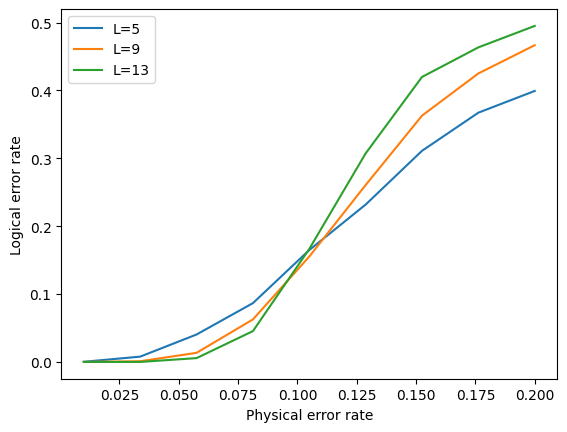

In [11]:
plt.figure()
for i in range(3):
    plt.plot(prob,logic_error_rate_all[i],label = "L={}".format(lattice[i]))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend()
plt.show()